In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from typing import *
import numpy as np
import pandas as pd
from functools import partial
import math
from pathlib import Path
from collections import defaultdict
from prettytable import PrettyTable
from scipy.stats import ks_2samp

import torch
from torch import Tensor, nn
import torch.nn.functional as F

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Funcs

In [5]:
Path('../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_5GeV_normal.txt').stem.split('_')

['Fe', '1cm', '5GeV', 'normal']

In [130]:
def get_dtheta_ddist(*,theta, mom, x0, deltaz=0.01):
    flight = deltaz/torch.cos(theta)
    n_x0 =  flight/x0
    theta0 = (SCATTER_COEF_A / mom) * torch.sqrt(n_x0) * (1 + (SCATTER_COEF_B * torch.log(n_x0)))
    z1,z2 = torch.randn(len(n_x0)), torch.randn(len(n_x0))
    dtheta = z1 * theta0
    ddist = flight * torch.sin(theta0) * ((z1 / math.sqrt(12)) + (z2 / 2))
    return dtheta, ddist

In [153]:
warnings.filterwarnings('ignore')
def get_scatters(file:Path, n_muons:Optional[int]=None, n_ks_samples:Optional[int]=None,
                 mat_lookup:Dict[str,str]={'Al':'aluminium', 'Cu':'copper', 'Fe':'iron', 'U':'uranium'}) -> Dict[str,Any]:
    r'''
    file example Fe_1cm_5GeV_normal.txt
    '''
    
    # Init layer
    layer = PassiveLayer(lw=Tensor([1,1]), z=1, size=0.1)
    try: layer(1)
    except: pass
    
    # prep data
    df = pd.read_csv(file)
    df['dx_muon'] = df.dx_muon/1000
    df['dy_muon'] = df.dy_muon/1000
    df['dtheta_x_muon'] = df.dtheta_x*torch.pi/180
    df['dtheta_y_muon'] = df.dtheta_y*torch.pi/180
    df['ddist_muon'] = np.sqrt(np.square(df.dx_muon)+np.square(df.dy_muon))
    df['dtheta_muon'] = df.dtheta_space*torch.pi/180
    
    # Get settings
    settings = file.stem.split('_')
    mat = mat_lookup[settings[0]]
    dz = float(settings[1][:settings[1].lower().find('cm')])/100
    mom = float(settings[2][:settings[2].lower().find('gev')])
    if settings[3] == 'normal':
        theta = 0.0
    elif settings[3] == 'ZenithAngle=pi4':
        theta = np.pi/4
    phi = 0
    if n_muons is None:
        n_muons = len(df) 
    else:
        raise ValueError(f'Unknown angle setting {settings[3]}')
    df = df.sample(n_muons, replace=n_muons > len(df))
    print(f'Making sims for {mat=}, {dz=}, {mom=}, {theta=}, {phi=}, {n_muons=}')
    if n_ks_samples is None: n_ks_samples=n_muons
        
    # Get sims
    xy_m_t_p = torch.ones(n_muons, 5)
    xy_m_t_p[:,2] = mom
    xy_m_t_p[:,3] = theta
    xy_m_t_p[:,4] = phi
    muons = MuonBatch(xy_m_t_p, init_z=1)
    x0 = torch.ones(len(muons)) * X0[mat]
    
    # New param model
    geant_scattering = layer._geant_scatter(x0=x0, deltaz=0.01, theta=muons.theta, mom=muons.mom)
    geant_scattering['dtheta_muon'] = np.sqrt((geant_scattering['dtheta']**2)+(geant_scattering['dphi']**2))
    geant_scattering['ddist_muon'] = np.sqrt((geant_scattering['dx']**2)+(geant_scattering['dy']**2))
    geant_scattering['dtheta_x_muon'] = geant_scattering.pop('dtheta')
    geant_scattering['dtheta_y_muon'] = geant_scattering.pop('dphi')
    geant_scattering['dx_muon'] = geant_scattering.pop('dx')
    geant_scattering['dy_muon'] = geant_scattering.pop('dy')
    
    # New PDG model
    dtheta_x, dx = get_dtheta_ddist(theta=muons.theta, mom=muons.mom, x0=x0, deltaz=dz)
    dtheta_y, dy = get_dtheta_ddist(theta=muons.theta, mom=muons.mom, x0=x0, deltaz=dz)
    dtheta = (dtheta_x.square()+dtheta_y.square()).sqrt()
    dxy = (dx.square()+dy.square()).sqrt()
    pdg_scattering = {'dtheta_x_muon':dtheta_x, 'dtheta_y_muon':dtheta_y, 'dx_muon':dx, 'dy_muon':dy, 'dtheta_muon':dtheta, 'ddist_muon':dxy}
    
    # Make plots and tests
    tests = defaultdict(lambda:defaultdict(dict))
    
    def get_ks(a, b) -> float:
        a = np.random.choice(a,size=min([n_ks_samples,len(a)]), replace=False)
        b = np.random.choice(b,size=min([n_ks_samples,len(b)]), replace=False)
        return ks_2samp(a, b).pvalue
    
    var = 'dtheta_muon'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean_fdiff'] = np.abs(sim[var].mean()-df[var].mean())/df[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var],95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var] <= cut95], df.loc[df[var]<=cut95,var])
        cut68 = np.percentile(df[var],68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var] <= cut68], df.loc[df[var]<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
   
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label=f'Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([0, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-3, 1e4)
    plt.show()
    
    print(tab)
    
    var = 'dtheta_x_muon'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-3, 1e4)
    plt.show()
    
    print(tab)
    
    
    var = 'dtheta_y_muon'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-3, 1e4)
    plt.show()
    
    print(tab)
    
    var = 'ddist_muon'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean_fdiff'] = np.abs(sim[var].mean()-df[var].mean())/df[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var],95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var] <= cut95], df.loc[df[var]<=cut95,var])
        cut68 = np.percentile(df[var],68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var] <= cut68], df.loc[df[var]<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
        
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label=f'Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([0, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-1, 1e6)
    plt.show()
    
    print(tab)
    
    var = 'dx_muon'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-1, 1e6)
    plt.show()
    
    print(tab)
    
    var = 'dy_muon'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-1, 1e6)
    plt.show()
    
    print(tab)
    
#     var = 'dtheta_y_muon'
#     print('\n\n',var)
#     cut = np.percentile(df[var].abs(),68)
    
#     sns.distplot(df.loc[df[var]>cut, var], label='True GEANT')
#     sns.distplot(geant_scattering[var][geant_scattering[var]>cut], label='Param GEANT')
#     sns.distplot(pdg_scattering[var][pdg_scattering[var]>cut], label='PDG')
#     plt.xlabel(var)
#     plt.legend()
#     plt.yscale('log')
# #     plt.ylim(1e-1,1e6)
# #     plt.xlim(0,1e-5)
#     plt.ylim(1e-5, 1e4)
# #     plt.xlim(0,1e-5)
#     plt.show()
#     print(tab)
    
    return {'data':{'df':df, 'param_geant':geant_scattering, 'pdg':pdg_scattering}, 'tests':tests}

In [137]:
val_path = Path('../../mode_muon_tomography_scattering/data/validation/new/')

In [89]:
val_data = list(val_path.glob('*.txt'))

In [93]:
for i,p in enumerate(val_data): print(i,p)

0 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_5GeV_ZenithAngle=pi4.txt
1 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_50GeV_normal.txt
2 ../../mode_muon_tomography_scattering/data/validation/new/Al_1cm_5GeV_normal.txt
3 ../../mode_muon_tomography_scattering/data/validation/new/U_1cm_5GeV_normal.txt
4 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_5GeV_normal.txt
5 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_1GeV_normal.txt
6 ../../mode_muon_tomography_scattering/data/validation/new/Cu_1cm_5GeV_normal.txt


Making sims for mat='iron', dz=0.01, mom=50.0, theta=0.0, phi=0, n_muons=100000


 dtheta_y_muon


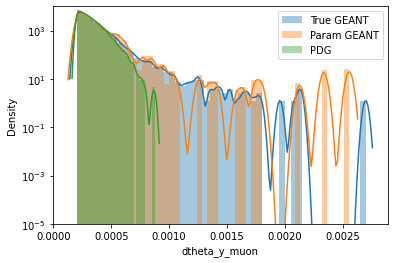

NameError: name 'tab' is not defined

In [86]:
results = get_scatters(val_data[1], n_ks_samples=None)

Making sims for mat='iron', dz=0.01, mom=5.0, theta=0.0, phi=0, n_muons=100000


 dtheta_muon


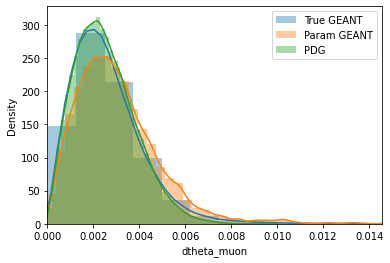

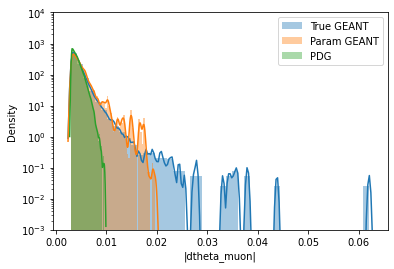

+-------------+----------------+----------------+-----------------------+-----------------------+-----------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p         |      bulk95_ks_p      |      bulk68_ks_p      |
+-------------+----------------+----------------+-----------------------+-----------------------+-----------------------+
|     pdg     | tensor(0.0454) | tensor(0.2295) | 3.458282937296693e-36 | 1.806784003504404e-14 | 2.319211549136427e-10 |
| param_geant | tensor(0.1683) | tensor(0.1499) |          0.0          |          0.0          | 8.348450160384654e-58 |
+-------------+----------------+----------------+-----------------------+-----------------------+-----------------------+


 dtheta_x_muon


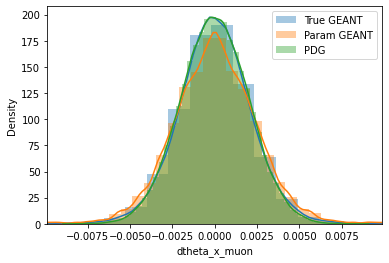

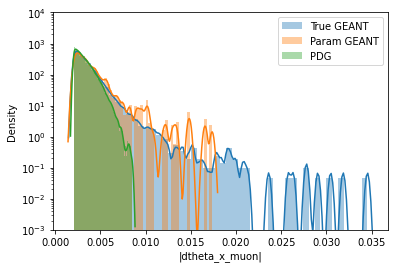

+-------------+---------------------+----------------+------------------------+-----------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p          |      bulk95_ks_p      |      bulk68_ks_p       |
+-------------+---------------------+----------------+------------------------+-----------------------+------------------------+
|     pdg     | tensor(-8.5263e-06) | tensor(0.1021) | 2.7323181040294805e-05 |  0.025758071495392554 |  0.16901675497473645   |
| param_geant |  tensor(1.8194e-06) | tensor(0.1564) | 8.340229594851407e-58  | 5.909393532445113e-34 | 3.8029659691544184e-07 |
+-------------+---------------------+----------------+------------------------+-----------------------+------------------------+


 dtheta_y_muon


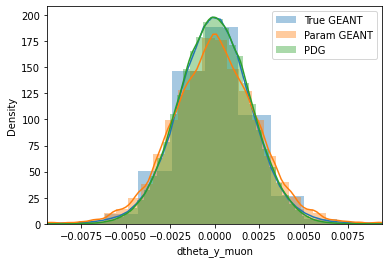

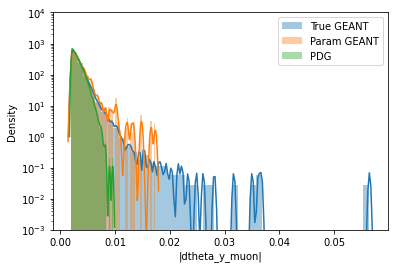

+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p      |      bulk68_ks_p      |
+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+
|     pdg     | tensor(-6.5178e-06) | tensor(0.0891) |  0.004825504162533915 |  0.013621373797345083 |   0.263527581320097   |
| param_geant |  tensor(3.9819e-06) | tensor(0.1695) | 4.304494966232881e-67 | 6.065288827483164e-36 | 2.502735615993386e-05 |
+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+


 ddist_muon


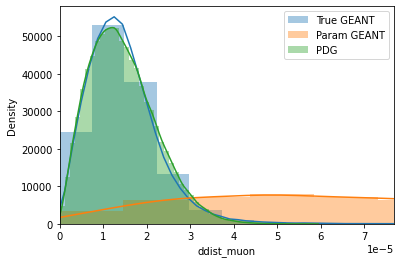

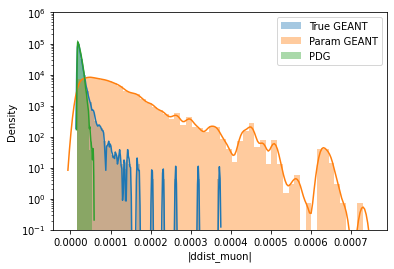

+-------------+----------------+----------------+------------------------+----------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p          |     bulk95_ks_p      |      bulk68_ks_p       |
+-------------+----------------+----------------+------------------------+----------------------+------------------------+
|     pdg     | tensor(0.0070) | tensor(0.1349) | 2.3939110325704606e-18 | 8.16513944405228e-26 | 1.4051255112885915e-10 |
| param_geant | tensor(5.5530) | tensor(7.8877) |          0.0           |         0.0          | 1.2219159936885251e-55 |
+-------------+----------------+----------------+------------------------+----------------------+------------------------+


 dx_muon


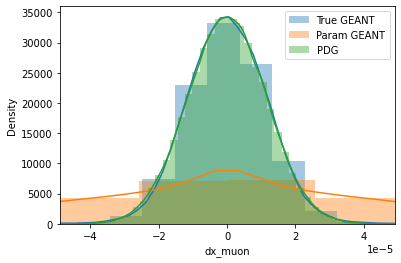

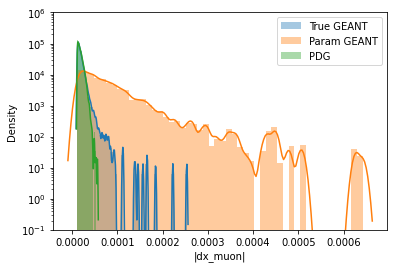

+-------------+---------------------+----------------+---------------------+-------------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |         ks_p        |       bulk95_ks_p       |      bulk68_ks_p       |
+-------------+---------------------+----------------+---------------------+-------------------------+------------------------+
|     pdg     | tensor(-5.1133e-08) | tensor(0.0426) | 0.10108550959309315 |   0.12766710797467196   |   0.3080052732483074   |
| param_geant | tensor(-9.6460e-08) | tensor(6.2679) |         0.0         | 1.3721130144809307e-161 | 1.491610668193238e-267 |
+-------------+---------------------+----------------+---------------------+-------------------------+------------------------+


 dy_muon


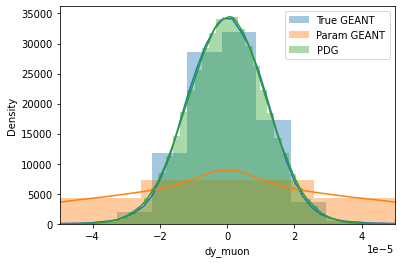

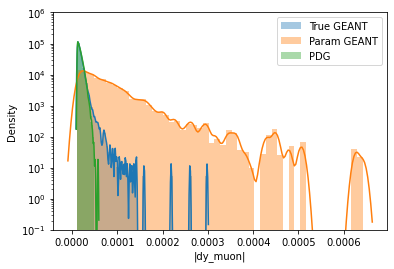

+-------------+--------------------+----------------+---------------------+-------------------------+-------------------------+
|     Sim     |        mean        |   std_fdiff    |         ks_p        |       bulk95_ks_p       |       bulk68_ks_p       |
+-------------+--------------------+----------------+---------------------+-------------------------+-------------------------+
|     pdg     | tensor(1.6177e-09) | tensor(0.0361) | 0.11143636657103861 |    0.1435243137458858   |   0.09882893632120715   |
| param_geant | tensor(1.7693e-07) | tensor(6.2248) |         0.0         | 3.2861955655587203e-155 | 2.7750443817237396e-261 |
+-------------+--------------------+----------------+---------------------+-------------------------+-------------------------+


In [156]:
results = get_scatters(val_data[4], n_ks_samples=None)

Making sims for mat='iron', dz=0.01, mom=50.0, theta=0.0, phi=0, n_muons=100000


 dtheta_muon


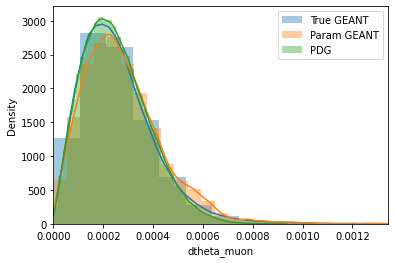

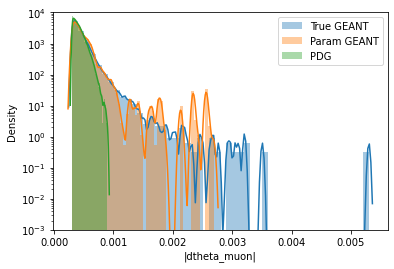

+-------------+----------------+----------------+------------------------+------------------------+-----------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p          |      bulk95_ks_p       |      bulk68_ks_p      |
+-------------+----------------+----------------+------------------------+------------------------+-----------------------+
|     pdg     | tensor(0.0364) | tensor(0.1919) | 6.847360959991456e-25  | 2.0033426637249418e-11 | 2.716291515578457e-06 |
| param_geant | tensor(0.0861) | tensor(0.1436) | 6.085948868382542e-146 | 9.060773666498057e-91  |  6.85108501960648e-27 |
+-------------+----------------+----------------+------------------------+------------------------+-----------------------+


 dtheta_x_muon


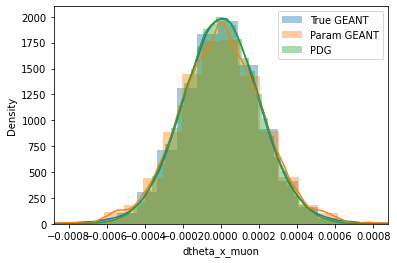

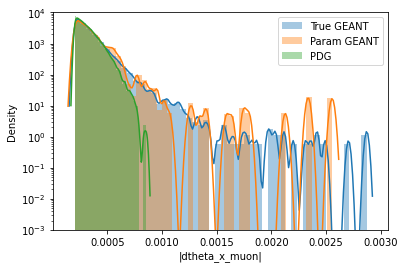

+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p      |      bulk68_ks_p      |
+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+
|     pdg     |  tensor(5.5165e-07) | tensor(0.0780) |  0.012511911965142692 |  0.15213831762849317  |   0.4500150879809607  |
| param_geant | tensor(-8.8278e-08) | tensor(0.1003) | 6.038948824770068e-16 | 7.135862263356488e-11 | 0.0006260682735976702 |
+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+


 dtheta_y_muon


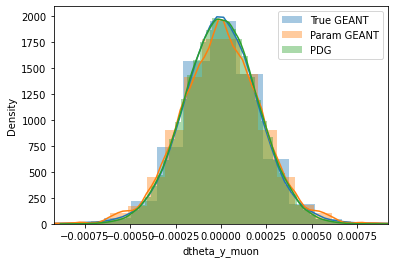

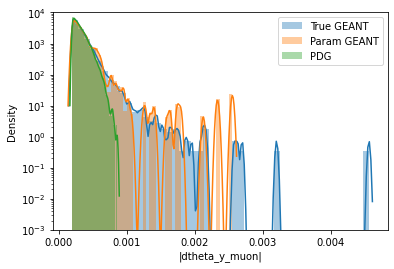

+-------------+--------------------+----------------+-----------------------+------------------------+------------------------+
|     Sim     |        mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+--------------------+----------------+-----------------------+------------------------+------------------------+
|     pdg     | tensor(1.2231e-06) | tensor(0.0764) |  0.006360844929502142 |  0.008189396388210498  |   0.0644578033886044   |
| param_geant | tensor(2.7160e-07) | tensor(0.1046) | 5.250694014426093e-19 | 1.7434084525192828e-13 | 1.1184388546960036e-05 |
+-------------+--------------------+----------------+-----------------------+------------------------+------------------------+


 ddist_muon


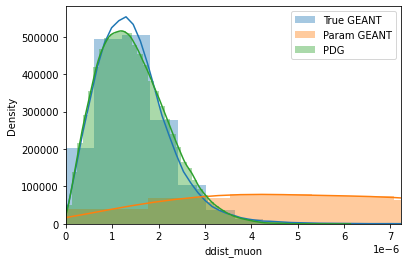

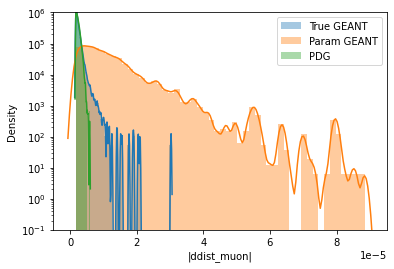

+-------------+----------------+----------------+-----------------------+------------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+----------------+----------------+-----------------------+------------------------+------------------------+
|     pdg     | tensor(0.0008) | tensor(0.0922) | 3.111845252169765e-29 | 1.9168760050800178e-34 | 2.7251147258215993e-17 |
| param_geant | tensor(5.4596) | tensor(8.2194) |          0.0          |          0.0           | 3.8937309355154756e-45 |
+-------------+----------------+----------------+-----------------------+------------------------+------------------------+


 dx_muon


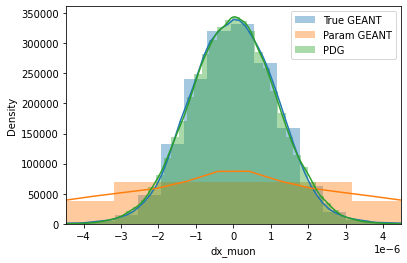

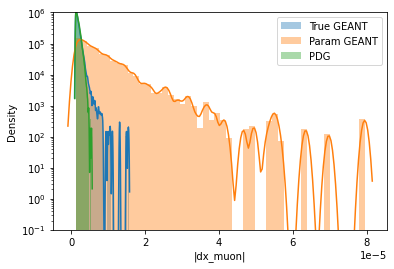

+-------------+--------------------+----------------+--------------------+------------------------+-------------------------+
|     Sim     |        mean        |   std_fdiff    |        ks_p        |      bulk95_ks_p       |       bulk68_ks_p       |
+-------------+--------------------+----------------+--------------------+------------------------+-------------------------+
|     pdg     | tensor(3.8552e-10) | tensor(0.0219) | 0.0689226350121781 |   0.1589740865745527   |   0.23832862440661684   |
| param_geant | tensor(5.0298e-08) | tensor(6.2568) |        0.0         | 7.777390715935881e-145 | 3.3560724758029975e-254 |
+-------------+--------------------+----------------+--------------------+------------------------+-------------------------+


 dy_muon


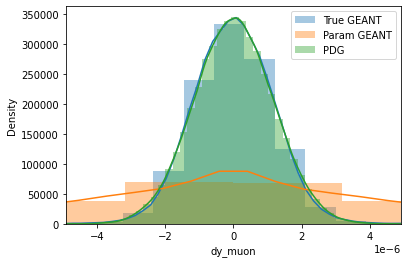

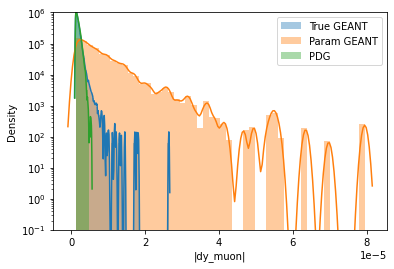

+-------------+--------------------+----------------+---------------------+-------------------------+------------------------+
|     Sim     |        mean        |   std_fdiff    |         ks_p        |       bulk95_ks_p       |      bulk68_ks_p       |
+-------------+--------------------+----------------+---------------------+-------------------------+------------------------+
|     pdg     | tensor(9.3557e-09) | tensor(0.0238) | 0.01037896353406525 |    0.0719757642545178   |   0.5473773666016748   |
| param_geant | tensor(1.7497e-08) | tensor(6.2391) |         0.0         | 1.3100891874979176e-149 | 1.535447423501609e-276 |
+-------------+--------------------+----------------+---------------------+-------------------------+------------------------+


In [154]:
results = get_scatters(val_data[1], n_ks_samples=None)

Making sims for mat='iron', dz=0.01, mom=5.0, theta=0.7853981633974483, phi=0, n_muons=100000


 dtheta_muon


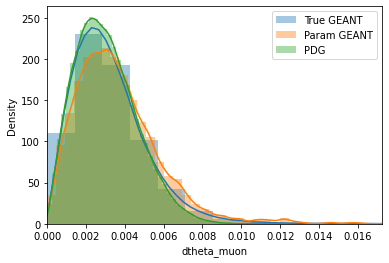

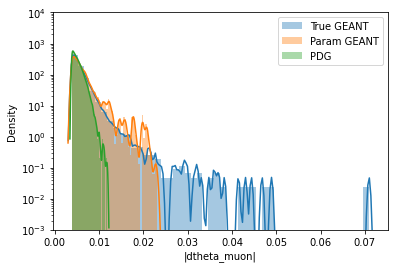

+-------------+----------------+----------------+-------------------------+-------------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |           ks_p          |       bulk95_ks_p       |      bulk68_ks_p       |
+-------------+----------------+----------------+-------------------------+-------------------------+------------------------+
|     pdg     | tensor(0.0670) | tensor(0.2302) |  6.410754191290998e-62  |  2.478938247839395e-05  |  0.008249321581563924  |
| param_geant | tensor(0.1289) | tensor(0.1443) | 1.6796313064547894e-287 | 1.9823282725596443e-193 | 2.9196421204197888e-36 |
+-------------+----------------+----------------+-------------------------+-------------------------+------------------------+


 dtheta_x_muon


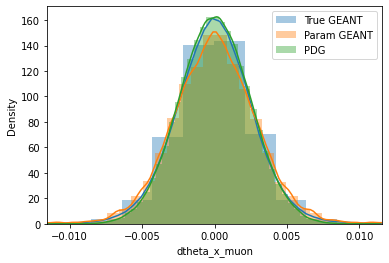

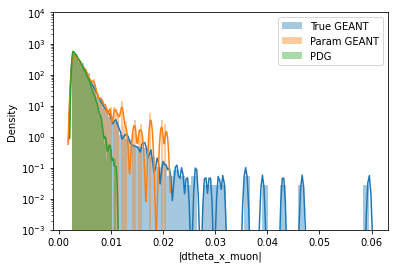

+-------------+--------------------+----------------+-----------------------+------------------------+-----------------------+
|     Sim     |        mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p      |
+-------------+--------------------+----------------+-----------------------+------------------------+-----------------------+
|     pdg     | tensor(1.0972e-05) | tensor(0.1084) | 3.152694088593283e-08 |  0.30653244501460297   |   0.2742745613011329  |
| param_geant | tensor(2.5780e-06) | tensor(0.1273) | 5.920188885401676e-38 | 1.1849088188198302e-19 | 7.264341368909939e-05 |
+-------------+--------------------+----------------+-----------------------+------------------------+-----------------------+


 dtheta_y_muon


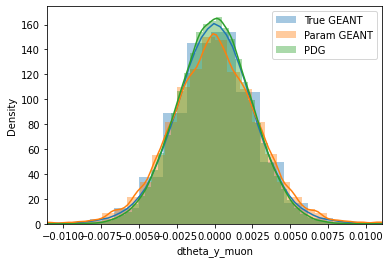

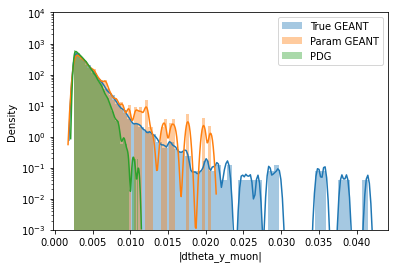

+-------------+---------------------+----------------+-----------------------+------------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+---------------------+----------------+-----------------------+------------------------+------------------------+
|     pdg     | tensor(-3.6542e-07) | tensor(0.1127) | 2.401026028574424e-07 |   0.5418877975007079   |   0.9117993567415658   |
| param_geant |  tensor(8.4377e-06) | tensor(0.1393) | 6.661227729729729e-35 | 1.2427544940161385e-19 | 0.00013187333717917622 |
+-------------+---------------------+----------------+-----------------------+------------------------+------------------------+


 ddist_muon


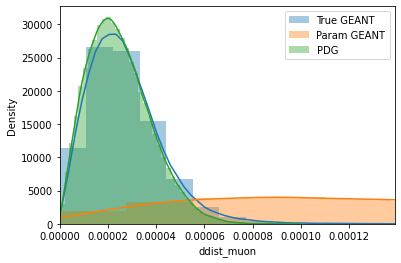

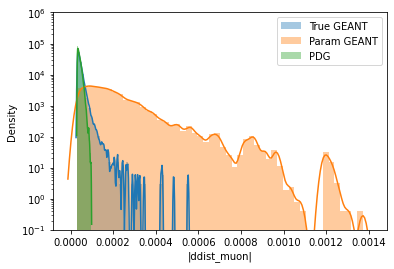

+-------------+----------------+----------------+-------------------------+-----------------------+-----------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |           ks_p          |      bulk95_ks_p      |      bulk68_ks_p      |
+-------------+----------------+----------------+-------------------------+-----------------------+-----------------------+
|     pdg     | tensor(0.0915) | tensor(0.2154) | 2.1480647615325411e-106 | 6.507046630311432e-51 | 7.381139766757939e-15 |
| param_geant | tensor(5.6466) | tensor(7.9484) |           0.0           |          0.0          | 5.042224368003486e-60 |
+-------------+----------------+----------------+-------------------------+-----------------------+-----------------------+


 dx_muon


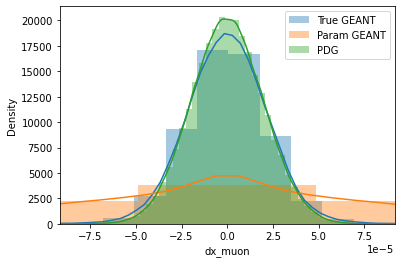

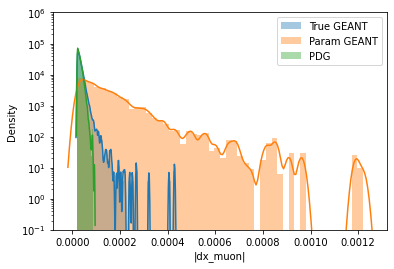

+-------------+--------------------+----------------+-----------------------+-------------------------+-----------------------+
|     Sim     |        mean        |   std_fdiff    |          ks_p         |       bulk95_ks_p       |      bulk68_ks_p      |
+-------------+--------------------+----------------+-----------------------+-------------------------+-----------------------+
|     pdg     | tensor(3.8975e-08) | tensor(0.1254) | 5.944065096110913e-19 |  6.632492901041628e-08  |  0.07158719087678544  |
| param_geant | tensor(3.6852e-07) | tensor(6.3067) |          0.0          | 3.5350502375928574e-159 | 2.37847293434072e-267 |
+-------------+--------------------+----------------+-----------------------+-------------------------+-----------------------+


 dy_muon


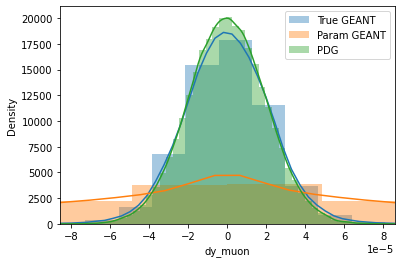

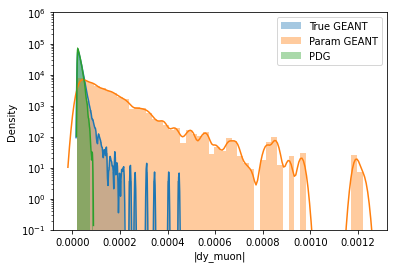

+-------------+---------------------+----------------+------------------------+-------------------------+-------------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p          |       bulk95_ks_p       |       bulk68_ks_p       |
+-------------+---------------------+----------------+------------------------+-------------------------+-------------------------+
|     pdg     | tensor(-7.9539e-08) | tensor(0.1207) | 1.4091635789390595e-18 |  5.943271954931494e-09  |   0.08727457283528461   |
| param_geant | tensor(-1.1976e-06) | tensor(6.3663) |          0.0           | 1.9872859730774064e-173 | 1.5263942590189938e-288 |
+-------------+---------------------+----------------+------------------------+-------------------------+-------------------------+


In [155]:
results = get_scatters(val_data[0], n_ks_samples=None)